In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [6]:
metro = pd.read_csv("./Stations/CDG.csv")

# Cleaning

In [9]:
metro['nearest_datetime'] = pd.to_datetime(metro['nearest_datetime'], format='%Y-%m-%d %H:%M:%S')

metro = metro.sort_values(by='destination_name', ascending=False)
metro['destination_name'] = pd.factorize(metro["destination_name"])[0]

metro = metro.sort_values(by='nearest_datetime', ascending=True)

metro["departure_status"] = metro["departure_status"].astype("string")
metro["is_day"] = metro["is_day"].astype(int)
metro['pourc_validations'] = metro['pourc_validations'].fillna(0)

metro = metro.drop(['stop_name', "real_departure", "real_arrival", "ArRTown", "Date", "day_type", "is_bank_holiday", "is_weekend"], axis=1)

# PCA

In [95]:
#Standardise numerical (non-categorical) variables
numerical_vars = metro.select_dtypes(include=['float64'])

scaler = StandardScaler()
numerical_vars_scaled = scaler.fit_transform(numerical_vars)

pca = PCA()
pca_results = pca.fit_transform(numerical_vars_scaled)

In [97]:
pca_df = pd.DataFrame(
    pca_results,
    columns=[f'PC{i+1}' for i in range(pca_results.shape[1])]
)

explained_variance = pca.explained_variance_ratio_

print("Explained Variance Ratio:", explained_variance)
print("PCA DataFrame Head:\n", pca_df.head())

Explained Variance Ratio: [0.15760687 0.12029451 0.10416756 0.07773183 0.07447552 0.06746917
 0.06532676 0.06123065 0.05313477 0.05283107 0.04794415 0.04183913
 0.02954459 0.02103585 0.01610134 0.00778593 0.00087229 0.00060801]
PCA DataFrame Head:
         PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.583873  0.121477  0.892372  0.322813 -4.329037 -0.724085  4.391226   
1 -1.490409 -0.152485  0.583737  1.131541 -4.264802 -0.797649  4.353260   
2 -1.298007 -0.242520  0.421519  1.850792 -4.347911 -1.110291  4.411258   
3 -1.350575 -0.451394  0.302254  0.995138 -4.305626 -1.054322  4.427768   
4  0.770743  0.801786 -0.428948 -1.853030 -1.071368  0.421032  1.072384   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0 -1.619175  1.640131  0.801768 -0.000172  3.622832 -1.120653  0.293601   
1 -0.874638  2.429540  0.032865  0.873302  3.529312 -1.087320  0.126820   
2 -0.003088  1.717597  0.876244  1.737915  3.395849 -1.014084  0.582543   


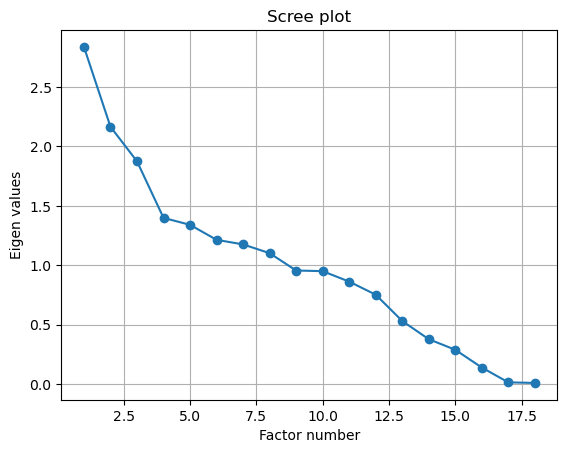

In [99]:
eigval = pca.explained_variance_

#Number of components (k)
k = len(eigval)

#Scree plot
plt.plot(np.arange(1, k + 1), eigval, marker='o')
plt.title("Scree plot")
plt.ylabel("Eigen values")
plt.xlabel("Factor number")
plt.grid(True)
plt.savefig('Screeplot_CDG.png', bbox_inches='tight', dpi=300)
plt.show()


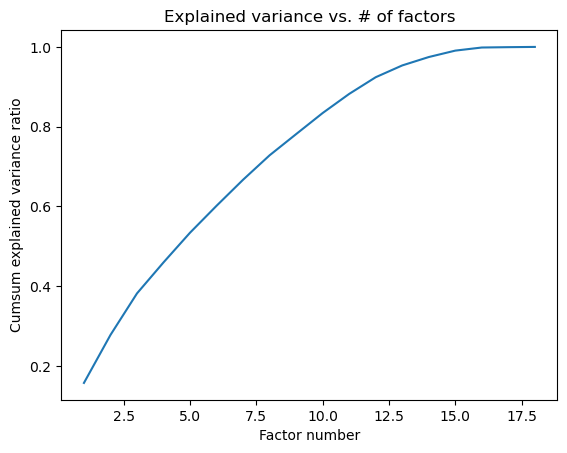

In [101]:
plt.plot(np.arange(1,k+1),np.cumsum(pca.explained_variance_ratio_)) 
plt.title("Explained variance vs. # of factors") 
plt.ylabel("Cumsum explained variance ratio") 
plt.xlabel("Factor number") 
plt.savefig('CumSumPlot_CDG.png', bbox_inches='tight', dpi=300)
plt.show()

In [109]:
## 10 factors picked for expainability

In [105]:
eigval

array([2.83715691, 2.16547925, 1.87517038, 1.39928807, 1.34066967,
       1.21454501, 1.17597836, 1.1022424 , 0.95650451, 0.95103741,
       0.86306564, 0.7531662 , 0.53184642, 0.37867637, 0.28984803,
       0.1401582 , 0.01570252, 0.01094516])

In [107]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.15760687 0.27790137 0.38206894 0.45980077 0.53427629 0.60174547
 0.66707222 0.72830288 0.78143765 0.83426871 0.88221286 0.92405199
 0.95359658 0.97463243 0.99073377 0.9985197  0.99939199 1.        ]


# Prediction

In [12]:
metro_learn = metro
metro_test = metro

start_date = pd.to_datetime('2024-11-02 00:00:00')
end_date = pd.to_datetime('2025-01-12 23:59:59')

start_date2 = pd.to_datetime('2025-01-13 00:00:00')
end_date2 = pd.to_datetime('2025-01-19 23:59:59')

metro_learn = metro_learn[(metro_learn['nearest_datetime'] >= start_date) & (metro_learn['nearest_datetime'] <= end_date)]
metro_test = metro_test[(metro_test['nearest_datetime'] >= start_date2) & (metro_test['nearest_datetime'] <= end_date2)]


# Logistic Regression

In [15]:
metro_learn = metro_learn.copy()
metro_learn.drop(['nearest_datetime'], axis=1, inplace=True)  # Drop the original datetime column if not needed
metro_test = metro_test.copy()
metro_test.drop(['nearest_datetime'], axis=1, inplace=True)  # Drop the original datetime column if not needed

In [17]:
metro_learn_X = metro_learn.drop('departure_status', axis=1)  # Features (exclude target)
metro_learn_Y = metro_learn['departure_status']  # Target variable
metro_learn_Y  = metro_learn_Y.apply(lambda x: 1 if x == 'delayed' else 0)

X_train, X_test, Y_train, Y_test = train_test_split(metro_learn_X, 
                                                    metro_learn_Y, 
                                                    test_size=0.2, 
                                                    random_state=2,
                                                    stratify=metro_learn_Y)

In [19]:
metro_learn_X = metro_learn.drop('departure_status', axis=1)  # (exclude target)
metro_learn_Y = metro_learn['departure_status']  # Target variable
metro_learn_Y  = metro_learn_Y.apply(lambda x: 1 if x == 'delayed' else 0)

X_train, X_test, Y_train, Y_test = train_test_split(metro_learn_X, 
                                                    metro_learn_Y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=metro_learn_Y)

In [21]:
#Numerical features => standard scaling 

numeric_features = ['temperature_2m', 'precipitation', 'wind_speed_10m', 'visibility']

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

In [23]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(penalty='elasticnet', solver='saga', max_iter=1000)) 
])

In [25]:
param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'model__l1_ratio': [0.1, 0.5, 0.7, 0.9],  # Elastic Net mix
}

In [27]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['temperature_2m',
                                                                          'precipitation',
                                                                          'wind_speed_10m',
                                                                          'visibility'])])),
                                       ('model',
                                        LogisticRegression(max_iter=1000,
                                                           penalty='elasticnet',
                                                           solver='saga'))]),
             param_grid={'model__C': [0.01, 0.1, 1, 10, 100],
                         'model__l1_ratio': [0.1, 0.5, 0.7, 0.9]},
             scoring='f1')

In [28]:
#Best model
best_model = grid_search.best_estimator_
print(best_model.get_params())

{'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['temperature_2m', 'precipitation',
                                  'wind_speed_10m', 'visibility'])])), ('model', LogisticRegression(C=0.01, l1_ratio=0.1, max_iter=1000, penalty='elasticnet',
                   solver='saga'))], 'verbose': False, 'preprocessor': ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['temperature_2m', 'precipitation',
                                  'wind_speed_10m', 'visibility'])]), 'model': LogisticRegression(C=0.01, l1_ratio=0.1, max_iter=1000, penalty='elasticnet',
                   solver='saga'), 'preprocessor__force_int_remainder_cols': True, 'preprocessor__n_jobs': None, 'preprocessor__remainder': 'drop', 'preprocessor__sparse_threshold': 0.3, 'preprocessor__transformer_weights': None, 'preprocessor__transformers': [('num', StandardScaler(), ['temperature_2m', 'precipit

In [29]:
metro_test_X = metro_test.drop('departure_status', axis=1)  # Features (exclude target)
metro_test_Y = metro_test['departure_status'] 
metro_test_Y = metro_test_Y.apply(lambda x: 1 if x == 'delayed' else 0)

In [30]:
y_pred_train = best_model.predict(X_train)    #the test set of the learn data
y_pred_test = best_model.predict(metro_test_X)

In [31]:
print(f"Training Accuracy: {accuracy_score(Y_train, y_pred_train):.4f}")
print(f"Test Accuracy: {accuracy_score(metro_test_Y, y_pred_test):.4f}")

Training Accuracy: 0.9711
Test Accuracy: 0.9813


In [32]:
train_pred_vs_true = pd.DataFrame({'True': Y_train, 
                                   'Predicted': y_pred_train})

test_pred_vs_true = pd.DataFrame({'True': metro_test_Y, 
                                  'Predicted': y_pred_test})

In [33]:
conf_matrix = confusion_matrix(metro_test_Y, y_pred_test)
print(conf_matrix)

[[1101    0]
 [  21    0]]


# Random Forest

In [35]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)  #% of missing values
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #create result table
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

print(missing_values_table(metro)) 

There are 0 columns that have missing values.
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


In [36]:
metro_learn_X = metro_learn.drop('departure_status', axis=1)  
metro_learn_Y = metro_learn['departure_status']

X_train, X_test, Y_train, Y_test = train_test_split(metro_learn_X, 
                                                    metro_learn_Y, 
                                                    test_size=0.2, 
                                                    random_state=42)


In [37]:
rf = RandomForestClassifier(random_state=42)

rf_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [38]:
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_cv = GridSearchCV(rf, rf_grid, cv=cv_folds, n_jobs=-1, scoring='accuracy')

In [39]:
rf_cv.fit(X_train, Y_train)

print(f"Best hyperparameters: {rf_cv.best_params_}")

Best hyperparameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [41]:
metro_test_X = metro_test.drop('departure_status', axis=1)  # Features (exclude target)
metro_test_Y = metro_test['departure_status']  # Target variable


In [45]:
#Evaluate the model on the test set
y_pred_train = rf_cv.predict(X_test)
y_pred_test = rf_cv.predict(metro_test_X)

print(f"Training Accuracy: {accuracy_score(Y_test, y_pred_train):.4f}")
print(f"Test Accuracy: {accuracy_score(metro_test_Y, y_pred_test):.4f}")

# Create DataFrames for plotting prediction vs true values
train_pred_vs_true = pd.DataFrame({'True': Y_test, 
                                   'Predicted': y_pred_train})

test_pred_vs_true = pd.DataFrame({'True': metro_test_Y, 
                                  'Predicted': y_pred_test})

Training Accuracy: 0.9999
Test Accuracy: 0.9991


In [115]:
#Confusion matrix
conf_matrix = confusion_matrix(metro_test_Y, y_pred_test)
print(conf_matrix)


[[  20    1]
 [   0 1101]]


In [117]:
metro_test['departure_status'].value_counts()

departure_status
onTime     1101
delayed      21
Name: count, dtype: Int64

In [119]:
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=['Actual delay', 'Actual onTime'],  # Replace with your class names
    columns=['Predicted delay', 'Predicted onTime']  # Replace with your class names
)

# Save the confusion matrix as a LaTeX table
latex_table = conf_matrix_df.to_latex(
    index=True,
    caption="Confusion Matrix",
    label="tab:confusion_matrix",
    column_format="|c|c|c|c|",  # Adjust column alignment if necessary
    bold_rows=True
)

# Write to a .tex file
with open("confusion_matrix_GBG.tex", "w") as f:
    f.write(latex_table)

print("Confusion matrix saved to LaTeX format in 'confusion_matrix.tex'")

Confusion matrix saved to LaTeX format in 'confusion_matrix.tex'
